In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import sys
sys.path.insert(0, '../')
import pandas as pd
import talib as ta
import numpy as np
from config import key_id, secret_key
from datetime import datetime 
from scipy import signal
import scipy
from pandas import DataFrame

In [2]:
data=pd.read_csv('data/JACK.csv')

In [3]:
def removal(signal, repeat):
    copy_signal = np.copy(signal)
    for j in range(repeat):
        for i in range(3, len(signal)):
            copy_signal[i - 1] = (copy_signal[i - 2] + copy_signal[i]) / 2
    return copy_signal

# Cleaning data


In [4]:
#converting timestamp row to timestamp type
data['timestamp']=pd.to_datetime(data['timestamp'])

In [5]:
data=data.set_index('timestamp').sort_index(ascending=False)

In [6]:
#Count ticks on unique days
day_tick_cnt = data.index.normalize()\
                     .value_counts()\
                     .to_frame().reset_index()

#Keep days that have ticks greater than 300
day_list=day_tick_cnt[~(day_tick_cnt['timestamp'] >= 300)]

In [7]:
len(day_tick_cnt)- len(day_list)

2016

In [8]:
#create date
data['date']=data.index.date

In [9]:
data.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [10]:
#if date is in data, keep the data
cond= data['date'].isin(day_list['index'])
data.drop(data[cond].index, inplace = True)

In [11]:
#data should now be cleaned of days where data is spotty
data.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [22]:
#create time frame of opening to one hour before closing/ after hours
data=pd.DataFrame.between_time(data,"14:30","20:00")

# Create Features
## Adding indicators

In [13]:
import talib.abstract as tab

In [14]:
#make sure to import these packages
from pandas import DataFrame
import talib.abstract as tab
#abstract automatically extracts the columns and periods from the data itself, no input required



#feel free to add or subtract more indicators for any other strategy you want to use
def populateindicators(dataframe) -> DataFrame:
        #make sure to remove these later
        #exponential moving averages
        dataframe['ema_high'] = tab.EMA(dataframe, timeperiod=5, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=5, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=5, price='low')
        dataframe['ema_high_slow'] = tab.EMA(dataframe, timeperiod=20, price='high')
        dataframe['dema'] = ta.DEMA(dataframe['close'], timeperiod=30)
        
        #mathematics
        
        macd=tab.MACD(dataframe, fastperiod=12, slowperiod=26, signalperiod=9)
        dataframe['macd'] = macd['macd']
        dataframe['macdsignal']=macd['macdsignal']
        dataframe['macdhist']=macd['macdhist']
        
        
        dataframe['rsi'] = tab.RSI(dataframe, timeperiod=20, price='close')
        stoch_fast = tab.STOCHF(dataframe, 10.0, 3.0, 0.0, 3.0, 0.0)
        dataframe['fastd'] = stoch_fast['fastd']
        dataframe['fastk'] = stoch_fast['fastk']
        dataframe['adx'] = tab.ADX(dataframe)
        dataframe['cci'] = tab.CCI(dataframe)
        
        #create time indicators
        dataframe['months']=dataframe.index.get_level_values(level='timestamp').month
        dataframe['dayofweek']=dataframe.index.get_level_values(level='timestamp').dayofweek
        dataframe['hourofday']=dataframe.index.get_level_values(level='timestamp').hour
        
        #required for graphing
        #remove for later only here for graphing visualizing
        bollinger =ta.BBANDS(data.close,timeperiod=10)
        dataframe['bb_lowerband'] = bollinger[2]
        dataframe['bb_upperband'] = bollinger[0]
        dataframe['bb_middleband'] = bollinger[1]

        
        #create row of labels/classification
        #if dataframe
            #dataframe['maxindex'] = tab.MAXINDEX(dataframe, timeperiod=30)
        
        
        
        
        return dataframe

In [15]:
data2=populateindicators(data).sort_index(ascending=True)

In [16]:
data2[230:290]

,open,high,low,close,volume,date,ema_high,ema_close,ema_low,ema_high_slow,...,fastd,fastk,adx,cci,months,dayofweek,hourofday,bb_lowerband,bb_upperband,bb_middleband
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 18:43:00,19.40,19.420,19.3900,19.4200,1800,2008-12-15,19.426847,19.426083,19.415696,19.434920,...,76.897436,76.923077,9.084645,-13.850928,12,0,18,19.345916,19.496064,19.42099
2008-12-15 18:44:00,19.42,19.420,19.4199,19.4199,2409,2008-12-15,19.430271,19.429125,19.428544,19.436491,...,84.589744,76.846154,8.848041,3.452424,12,0,18,19.342859,19.495121,19.41899
2008-12-15 18:45:00,19.42,19.420,19.4200,19.4200,100,2008-12-15,19.435407,19.433737,19.432866,19.438227,...,92.307692,76.923077,9.264278,-7.633588,12,0,18,19.340032,19.493968,19.41700
2008-12-15 18:46:00,19.45,19.450,19.4500,19.4500,200,2008-12-15,19.443110,19.440606,19.439299,19.440145,...,90.740741,100.000000,9.714825,42.257218,12,0,18,19.337411,19.492589,19.41500
2008-12-15 18:47:00,19.45,19.450,19.4500,19.4500,100,2008-12-15,19.439665,19.435909,19.433948,19.439108,...,81.481481,100.000000,10.025580,44.422178,12,0,18,19.335703,19.484297,19.41000
2008-12-15 18:48:00,19.45,19.450,19.4500,19.4500,200,2008-12-15,19.434498,19.428863,19.425922,19.437961,...,68.518519,72.222222,10.360239,36.842105,12,0,18,19.334345,19.487655,19.41100
2008-12-15 18:49:00,19.44,19.450,19.4400,19.4500,200,2008-12-15,19.426747,19.418294,19.413884,19.436694,...,59.259259,72.222222,10.720641,24.911032,12,0,18,19.327250,19.502750,19.41500
2008-12-15 18:52:00,19.45,19.450,19.4300,19.4300,600,2008-12-15,19.415121,19.402441,19.400825,19.435293,...,35.185185,61.111111,11.108766,1.545254,12,0,18,19.323851,19.512149,19.41800
2008-12-15 18:54:00,19.42,19.420,19.4000,19.4000,900,2008-12-15,19.397681,19.388662,19.386238,19.433745,...,17.592593,44.444444,11.526747,-48.160000,12,0,18,19.324153,19.513847,19.41900


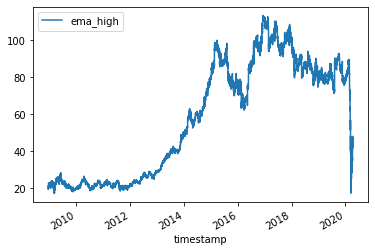

In [17]:
data2.plot(y='ema_high')

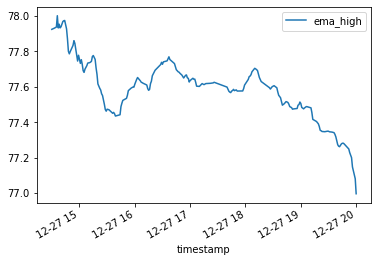

In [21]:
data2['2019-12-27'].plot(y='ema_high')

In [ ]:
tryse=tab.MAXINDEX(data2, timeperiod=60)

In [ ]:
#listtt=[]
    #for i in range(len(data2))
    

In [ ]:
data2['2015-12-29']

In [ ]:
data3=pd.DataFrame.between_time(data2,"14:00","20:00")

In [ ]:
data3['2015-12-29'].plot(y=['ema_high','ema_high_slow'])

In [ ]:
data3['2015-12-28'].plot(y='fastd')

In [ ]:
tryse=tab.MAXINDEX(data3['2015-12-29'], timeperiod=60)

In [112]:
months=data3.index.get_level_values(level='timestamp').month

In [128]:
res = data['timestamp'].dt.normalize()\
                     .value_counts()\
                     .to_frame().reset_index()

In [129]:
res

,index,timestamp
0,2016-02-18,539
1,2016-05-11,515
2,2016-02-17,509
3,2017-05-16,505
4,2017-02-22,483
5,2017-05-17,483
6,2015-02-17,479
7,2015-02-18,464
8,2017-08-09,458
9,2014-11-18,450


# labelling buy and sell signals

In [ ]:
#set the maximum and the minimum per day
data3[day]=

In [ ]:
#remove days with less than 200 ticks

In [ ]:
day_list

In [ ]:
#loop per day
#for every day in daylist
for day in day_list:
    
    #set the maximum and the minimum per day
    data3[day]=
    #create average day line
    data3[day]
    #creating the standard deviation per day

    #calculate stds to peak that day


    #calculate stds to trough that day

    
    #segmenting: if ema close of that position is 

In [ ]:
data3[day_list[1]]

In [ ]:
#save the data as a new 

In [ ]:
.to_pickle